    Настало время потренироваться в очистке данных! В этот раз тема особенно важная — поговорим о диабете.

Вам предоставлен набор данных, первоначально полученный в Национальном институте диабета, болезней органов пищеварения и почек. 

Этот набор данных создан для того, чтобы на основе определённых диагностических измерений предсказать, есть ли у пациента диабет. 

На выбор этих экземпляров из более крупной базы данных было наложено несколько ограничений. В частности, все пациенты здесь — женщины не моложе 21 года индейского происхождения Пима.

Прочитаем наши данные и выведем первые пять строк таблицы:

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

diabetes = pd.read_csv('data/diabetes_data.csv')

display(diabetes)
diabetes['Pregnancies'].max()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Gender
0,6,98,58,33,190,34.0,0.430,43,0,Female
1,2,112,75,32,0,35.7,0.148,21,0,Female
2,2,108,64,0,0,30.8,0.158,21,0,Female
3,8,107,80,0,0,24.6,0.856,34,0,Female
4,7,136,90,0,0,29.9,0.210,50,0,Female
...,...,...,...,...,...,...,...,...,...,...
773,6,103,72,32,190,37.7,0.324,55,0,Female
774,1,71,48,18,76,20.4,0.323,22,0,Female
775,0,117,0,0,0,33.8,0.932,44,0,Female
776,4,154,72,29,126,31.3,0.338,37,0,Female


17

Pregnancies — количество беременностей.

Glucose — концентрация глюкозы в плазме через два часа при пероральном тесте на толерантность к глюкозе.

BloodPressure — диастолическое артериальное давление (мм рт. ст.).

SkinThickness — толщина кожной складки трицепса (мм).

Insulin — двухчасовой сывороточный инсулин (ме Ед/мл).

BMI — индекс массы тела

DiabetesPedigreeFunction — функция родословной диабета (чем она выше, тем выше шанс наследственной заболеваемости).

Age — возраст.

Outcome — наличие диабета (0 — нет, 1 — да).

    Предварительно вы можете провести небольшой разведывательный анализ: посмотреть на распределения признаков и оценить их взаимосвязь с признаком наличия диабета.

Text(0, 0.5, 'двухчасовой сывороточный инсулин')

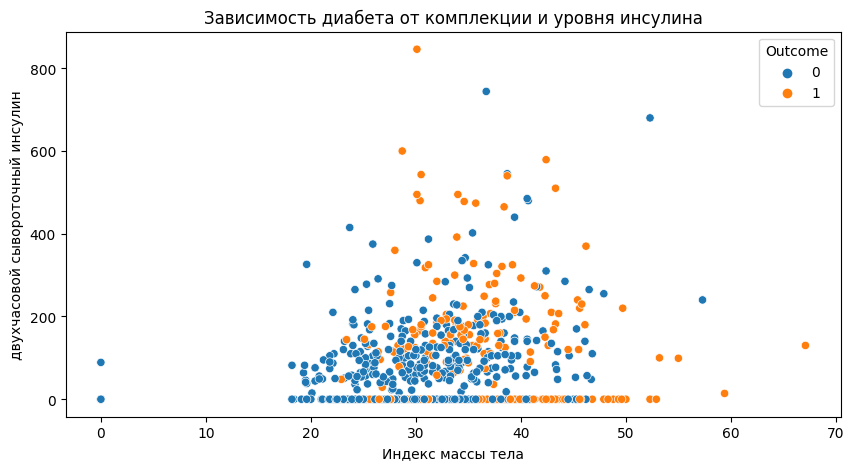

In [8]:
fig = plt.figure(figsize=(10, 5))

scatterplot = sns.scatterplot(
    data=diabetes,
    x='BMI',
    y='Insulin',
    hue='Outcome'
);

plt.title('Зависимость диабета от комплекции и уровня инсулина')
plt.xlabel('Индекс массы тела')
plt.ylabel('двухчасовой сывороточный инсулин')

Text(0, 0.5, 'Кровяное давление')

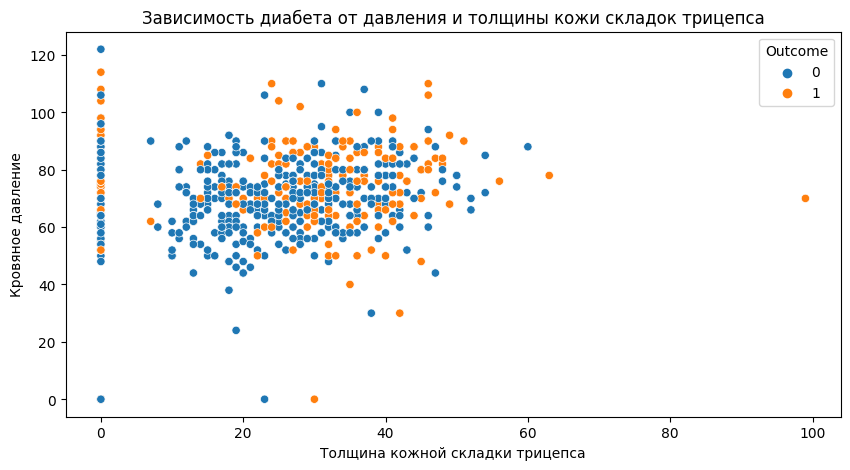

In [7]:
fig = plt.figure(figsize=(10, 5))

scatterplot = sns.scatterplot(
    data=diabetes,
    x='SkinThickness',
    y='BloodPressure',
    hue='Outcome'
);

plt.title('Зависимость диабета от давления и толщины кожи складок трицепса')
plt.xlabel('Толщина кожной складки трицепса')
plt.ylabel('Кровяное давление')

Text(0, 0.5, 'Количество беременностей')

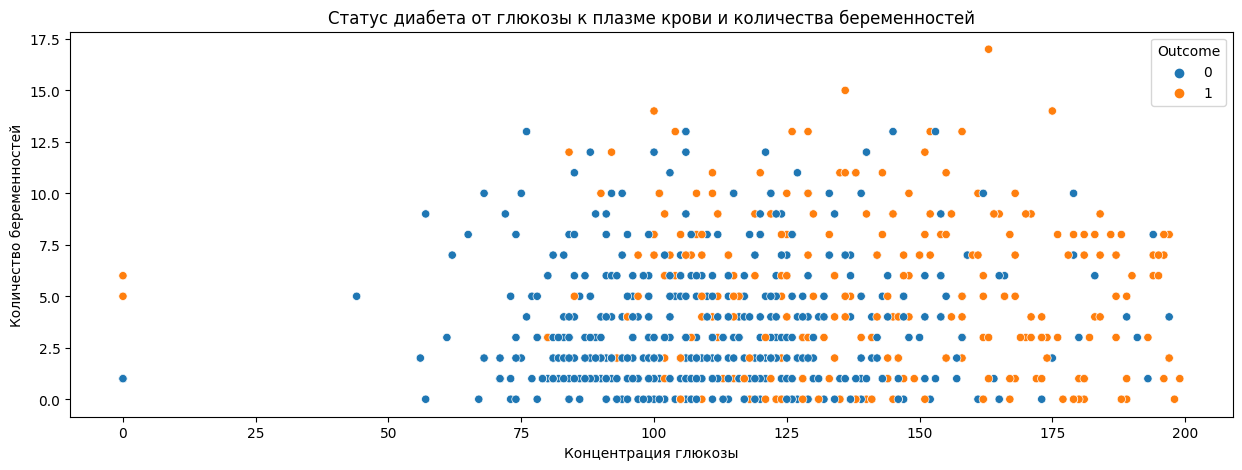

In [12]:
fig = plt.figure(figsize=(15, 5))

scatterplot = sns.scatterplot(
    data=diabetes,
    x='Glucose',
    y='Pregnancies',
    hue='Outcome'
);

plt.title('Статус диабета от глюкозы к плазме крови и количества беременностей')
plt.xlabel('Концентрация глюкозы')
plt.ylabel('Количество беременностей')